In [5]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')


sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]


sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
 
symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
# 8 years ago

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  502 of 502 completed

5 Failed downloads:
['AMTM', 'SOLV', 'GEV', 'SW', 'VLTO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375296   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595575   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718925   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145821   39.500000   40.150002   39.029999   39.259998   
           ACGL     24.416668   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.254005   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017845  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717117  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[980448 rows x 6 columns]

In [57]:
# adjusted close is different from close price:
# The closing price is the raw price, which is just the cash value of the last transacted price before the market closes. 
# The adjusted closing price factors in anything that might affect the stock price after the market closes.
# A stock's price is typically affected by the supply and demand of market participants. 
# However, some corporate actions, such as stock splits, dividends, and rights offerings, affect a stock's price.

# Calculate Garman-Klass volatility


In [58]:
#df.groupby(level = 1)['adj close']

In [59]:
'''import os
cwd = os.getcwd()
cwd'''

'import os\ncwd = os.getcwd()\ncwd'

<img src="EM.png">

In [6]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low'])**2))/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

In [7]:
#Calc RSI
#RSI measures the speed and magnitude of a security's recent price changes to detect overbought or oversold conditions in the price of that security.
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

There are two major differences between the transform and apply groupby methods.

Input:
- apply implicitly passes all the columns for each group as a DataFrame to the custom function.
- while transform passes each column for each group individually as a Series to the custom function.

Output:
- The custom function passed to apply can return a scalar, or a Series or DataFrame (or numpy array or even list).
- The custom function passed to transform must return a sequence (a one dimensional Series, array or list) the same  length as the group.

So, transform works on just one Series at a time and apply works on the entire DataFrame at once.

In [8]:
# Bollinger bands
# are envelopes plotted at a standard deviation level above and below a simple moving average of the price. 
# Because the distance of the bands is based on standard deviation, they adjust to volatility swings in the underlying price.

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# moving average : calculated by adding up all the data points during a specific period and dividing the sum by the number of time periods. 


In [9]:
# calculating ATR (Average True Range)
#Simply put, a stock experiencing a high level of volatility has a higher ATR,
#  and a lower ATR indicates lower volatility for the period evaluated.
#The indicator does not indicate the price direction; instead, 
# it is used primarily to measure volatility caused by gaps and limit up or down moves. 
#The ATR is commonly used as an exit method that can be applied no matter how the entry decision is made.
#One popular technique is known as the "chandelier exit" and was developed by Chuck LeBeau. 
# The chandelier exit places a trailing stop under the highest high the stock has reached since you entered the trade.

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())  # standardise it because we are applying a ML model

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)
# use apply instead of transform, cuz this calculation involves multiple columns

 
# MACD   ( moving average convergence/divergence )

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())    

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

#dollar volume
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6


In [10]:
df

#everything is normalised except RSI for particular reason

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.375296   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.595575   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.718925   52.790001   54.189999   51.880001   53.099998   
           ABT      33.145821   39.500000   40.150002   39.029999   39.259998   
           ACGL     24.416668   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.254005   89.519997   90.849998   89.500000   90.379997   
           YUM     121.017845  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.287468  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     174.717117  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -4.375538        NaN       NaN   
           AAPL    293461600.0         -3.761450        NaN       NaN   
           ABBV     12842800.0         -5.861518        NaN       NaN   
           ABT      12287500.0         -4.878419        NaN       NaN   
           ACGL      1888800.0         -3.464825        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -7.844704  26.146780  4.480372   
           YUM       1500600.0         -9.183290  36.057150  4.801976   
           ZBH       3610500.0         -8.769121  31.893237  4.743683   
           ZBRA       355400.0        -11.896889  29.494977  5.400991   
           ZTS       1463200.0        -10.782769  42.623477  5.151393   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.669716  
           AAPL         NaN       NaN       NaN       NaN    7217.856890  
           ABBV         NaN       NaN       NaN       NaN     458.731016  
           ABT          NaN       NaN       NaN       NaN     407.279271  
           ACGL         NaN       NaN       NaN       NaN      46.118202  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.562291  4.644210  0.033800 -2.159189     116.707097  
           YUM     4.831939  4.861902  0.142547 -1.363695     181.599378  
           ZBH     4.783349  4.823015 -0.381708 -0.881067     401.803403  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.210205  5.269017  0.651515 -1.188278     255.646086  

[980448 rows x 14 columns]

3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

-To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.


In [65]:
'''df.unstack('ticker')['dollar_volume']'''

"df.unstack('ticker')['dollar_volume']"

In [66]:
'''df.unstack('ticker')['dollar_volume'].resample('M').mean()'''
#Resample time-series data.

#Convenience method for frequency conversion and resampling of time series. The object must have a datetime-like inde

"df.unstack('ticker')['dollar_volume'].resample('M').mean()"

In [67]:
'''df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')
'''

"df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')\n"

In [11]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']] 
last_cols
# last_cols represents the features of the data we created that we will feed to machine,


['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [69]:
'''df.unstack()[last_cols].resample('M').last()'''
#last() For a DataFrame with a sorted DatetimeIndex, this function selects the last few rows based on a date offset.

"df.unstack()[last_cols].resample('M').last()"

In [70]:
'''df.unstack()[last_cols].resample('M').last().stack('ticker')'''

"df.unstack()[last_cols].resample('M').last().stack('ticker')"

In [12]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.525158   38.888996         -5.083077  73.421567   
           AAPL      4014.914473   26.793612         -4.025309  55.537333   
           ABBV       331.841257   39.708744         -6.257483  49.376858   
           ABT        209.554436   37.912792         -5.341942  56.962460   
           ACGL        29.629264   24.156668         -3.468013  35.682541   
...                          ...         ...               ...        ...   
2023-09-30 PLTR       651.345225   13.960000         -2.134068  41.544692   
           ABNB      1633.500725  132.279999         -9.441407  44.494127   
           CEG        196.304720  107.661484         -8.600679  55.245464   
           GEHC       212.127124   66.083885         -6.678857  40.922355   
           KVUE       664.360311   19.814007         -3.040429  35.706328   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.542646  3.615088  3.687529 -1.033887  0.567157  
           AAPL    3.279507  3.322815  3.366124 -0.967900 -0.142790  
           ABBV    3.710011  3.758240  3.806469 -0.526809  0.145677  
           ABT     3.646322  3.668170  3.690018 -1.064842  0.335556  
           ACGL    3.226274  3.243525  3.260776 -1.155694 -0.550166  
...                     ...       ...       ...       ...       ...  
2023-09-30 PLTR    2.701939  2.779743  2.857548 -0.426167 -0.433581  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.650304  4.690476  4.730649 -0.436215  0.366876  
           GEHC    4.154746  4.212281  4.269817 -0.893478 -1.116463  
           KVUE    3.005097  3.080010  3.154924 -0.899746 -1.435621  

[46293 rows x 9 columns]

calculate 5 year rolling average dollar volume of each stock, filter out the 150 most liquid stocks

In [13]:
data['dollar_volume'].unstack('ticker').rolling(5*12).mean()
# rolling() Provide rolling window calculations.

ticker,A,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,UBER,CTVA,CRWD,CARR,OTIS,PLTR,ABNB,CEG,GEHC,KVUE
date,,,,,,,,,,,,,,,,,,,,,
2015-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,189.565971,10673.098047,668.759967,516.597493,76.987357,498.683768,1131.536101,406.492692,162.244776,318.435397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-30,191.214690,10786.396782,673.209037,520.674951,78.205346,506.888226,1156.604909,413.769326,163.232767,319.393985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-31,193.272759,10888.478320,678.543211,524.412962,80.791199,511.237077,1172.120773,421.069406,164.735632,322.491934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
# ticker with smallest dollar volume has highest rank
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.525158   38.888996         -5.083077  73.421567   
           AAPL      4014.914473   26.793612         -4.025309  55.537333   
           ABBV       331.841257   39.708744         -6.257483  49.376858   
           ABT        209.554436   37.912792         -5.341942  56.962460   
           ACGL        29.629264   24.156668         -3.468013  35.682541   
...                          ...         ...               ...        ...   
2023-09-30 PLTR       651.345225   13.960000         -2.134068  41.544692   
           ABNB      1633.500725  132.279999         -9.441407  44.494127   
           CEG        196.304720  107.661484         -8.600679  55.245464   
           GEHC       212.127124   66.083885         -6.678857  40.922355   
           KVUE       664.360311   19.814007         -3.040429  35.706328   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2015-11-30 A       3.542646  3.615088  3.687529 -1.033887  0.567157   
           AAPL    3.279507  3.322815  3.366124 -0.967900 -0.142790   
           ABBV    3.710011  3.758240  3.806469 -0.526809  0.145677   
           ABT     3.646322  3.668170  3.690018 -1.064842  0.335556   
           ACGL    3.226274  3.243525  3.260776 -1.155694 -0.550166   
...                     ...       ...       ...       ...       ...   
2023-09-30 PLTR    2.701939  2.779743  2.857548 -0.426167 -0.433581   
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854   
           CEG     4.650304  4.690476  4.730649 -0.436215  0.366876   
           GEHC    4.154746  4.212281  4.269817 -0.893478 -1.116463   
           KVUE    3.005097  3.080010  3.154924 -0.899746 -1.435621   

                   dollar_vol_rank  
date       ticker                   
2015-11-30 A                 192.0  
           AAPL                2.0  
           ABBV               60.0  
           ABT               116.0  
           ACGL              437.0  
...                            ...  
2023-09-30 PLTR               58.0  
           ABNB               16.0  
           CEG               251.0  
           GEHC              236.0  
           KVUE               56.0  

[46293 rows x 10 columns]

In [15]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
# Now we have filtered out the top 150 most liquid stocks, we can remove the 2 columns
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2015-11-30 AAPL     26.793612         -4.025309  55.537333  3.279507   
           ABBV     39.708744         -6.257483  49.376858  3.710011   
           ABT      37.912792         -5.341942  56.962460  3.646322   
           ACN      92.853279         -8.590309  59.371866  4.510091   
           ADBE     91.459999         -7.915940  61.571429  4.501711   
...                       ...               ...        ...       ...   
2023-09-30 UBER     44.270000         -5.256290  45.005268  3.806654   
           CRWD    160.479996        -10.261167  51.534803  5.026187   
           PLTR     13.960000         -2.134068  41.544692  2.701939   
           ABNB    132.279999         -9.441407  44.494127  4.857047   
           KVUE     19.814007         -3.040429  35.706328  3.005097   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2015-11-30 AAPL    3.322815  3.366124 -0.967900 -0.142790  
           ABBV    3.758240  3.806469 -0.526809  0.145677  
           ABT     3.668170  3.690018 -1.064842  0.335556  
           ACN     4.534417  4.558743 -1.121687  0.039553  
           ADBE    4.520618  4.539526 -1.229336 -0.023303  
...                     ...       ...       ...       ...  
2023-09-30 UBER    3.862227  3.917801 -0.746098 -0.133973  
           CRWD    5.103696  5.181204 -0.744862  0.245950  
           PLTR    2.779743  2.857548 -0.426167 -0.433581  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  
           KVUE    3.080010  3.154924 -0.899746 -1.435621  

[14155 rows x 8 columns]

In [75]:
# the processes aboe can be generalised into the code below
'''data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data
'''

"data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())\n\ndata['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))\n\ndata = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)\n\ndata\n"

4. Calculate Monthly Returns for different time horizons as features.


- this is a new feature to be created

- To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [76]:
'''g = df.xs('AAPL', level=1)
g
'''

"g = df.xs('AAPL', level=1)\ng\n"

In [16]:
def calculate_returns(df):
    lags = [1,2,3,6,9,12]  #lags are durations? unit months. We calculate returns for these lags.

    outlier_cutoff = 0.005      #outlier cutoffs. If outlier, assign the threshold of that percentile

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                    upper =x.quantile(1-outlier_cutoff) ))
                                                    
                                                    .add(1)
                                                    .pow(1/lag)
                                                    .sub(1))
    return df

data = data.groupby(level=1, group_keys= False).apply(calculate_returns).dropna()

data 


adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-11-30 AAPL     25.588459         -3.835937  48.015344  3.247287   
           ABBV     43.123379         -6.411630  49.727681  3.705467   
           ABT      32.940113         -4.804340  39.665348  3.520607   
           ACN     105.517776         -9.046031  54.807775  4.639749   
           ADBE    102.809998         -8.402354  42.513577  4.634046   
...                       ...               ...        ...       ...   
2023-09-30 MRNA     98.120003         -8.205136  38.747314  4.582514   
           UBER     44.270000         -5.256290  45.005268  3.806654   
           CRWD    160.479996        -10.261167  51.534803  5.026187   
           PLTR     13.960000         -2.134068  41.544692  2.701939   
           ABNB    132.279999         -9.441407  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2016-11-30 AAPL    3.276350  3.305413 -1.011998 -0.314781  -0.021601   
           ABBV    3.779590  3.853713 -0.617478 -0.257987   0.089997   
           ABT     3.557048  3.593490 -0.981659 -0.575624  -0.029817   
           ACN     4.663627  4.687504 -0.928960  0.031424   0.027443   
           ADBE    4.665796  4.697545 -1.162212 -0.277852  -0.043717   
...                     ...       ...       ...       ...        ...   
2023-09-30 MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           CRWD    5.103696  5.181204 -0.744862  0.245950  -0.015641   
           PLTR    2.779743  2.857548 -0.426167 -0.433581  -0.068091   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2016-11-30 AAPL    -0.008718   0.015430   0.018834   0.016838   -0.003828  
           ABBV    -0.013645  -0.014453  -0.002749   0.015097    0.006898  
           ABT     -0.048194  -0.030325  -0.004603   0.000125   -0.011648  
           ACN     -0.006148   0.016178   0.002371   0.021900    0.010712  
           ADBE    -0.026754   0.001626   0.005520   0.021162    0.009796  
...                      ...        ...        ...        ...         ...  
2023-09-30 MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           PLTR    -0.161174  -0.030723   0.103769   0.053141    0.013289  
           ABNB    -0.067704   0.010603   0.010289   0.048608    0.019401  

[11162 rows x 14 columns]

5. Download Fama-French Factors and Calculate Rolling Factor Betas.

- We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

- The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

- We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [17]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()  # turn index to type: pd.time series

factor_data = factor_data.resample('M').last().div(100)# originally index of date is at start of month, but we must change to it end of month to match data above
# values are in percentages, we must divide by 100 to get decimal
factor_data.index.name = 'date'
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0322,-0.0027,0.0142
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0005,-0.0244,0.0130,-0.0022
...,...,...,...,...,...
2024-06-30,0.0277,-0.0437,-0.0331,0.0051,-0.0178
2024-07-31,0.0124,0.0828,0.0574,0.0022,0.0043
2024-08-31,0.0161,-0.0365,-0.0113,0.0085,0.0086


In [27]:
'''factor_data # original , start of month'''

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0322,-0.0027,0.0142
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0005,-0.0244,0.0130,-0.0022
...,...,...,...,...,...
2024-06-30,0.0277,-0.0437,-0.0331,0.0051,-0.0178
2024-07-31,0.0124,0.0828,0.0574,0.0022,0.0043
2024-08-31,0.0161,-0.0365,-0.0113,0.0085,0.0086


In [28]:
'''factor_data.resample('M').last()  # altered, end of month'''

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0322,-0.0027,0.0142
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0005,-0.0244,0.0130,-0.0022
...,...,...,...,...,...
2024-06-30,0.0277,-0.0437,-0.0331,0.0051,-0.0178
2024-07-31,0.0124,0.0828,0.0574,0.0022,0.0043
2024-08-31,0.0161,-0.0365,-0.0113,0.0085,0.0086


Join the final factor data dataframe with return_1m column of old dataframe. We do this so we can regress the datas to get beta values.

In [18]:
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-11-30 AAPL    0.0486  0.0707  0.0821 -0.0018  0.0369  -0.021601
           ABBV    0.0486  0.0707  0.0821 -0.0018  0.0369   0.089997
           ABT     0.0486  0.0707  0.0821 -0.0018  0.0369  -0.029817
           ACN     0.0486  0.0707  0.0821 -0.0018  0.0369   0.027443
           ADBE    0.0486  0.0707  0.0821 -0.0018  0.0369  -0.043717
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.056890
           WBA    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.461367
           WFC    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.015500
           WMT    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.000677
           XOM    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.046947

[11162 rows x 6 columns]

In [81]:
# factor_data.groupby(level=1).size() 

#each size for each stock is number of months the stock has data

ticker
AAPL    83
ABBV    83
ABNB    21
ABT     83
ACN     83
        ..
WMT     83
WYNN    48
XOM     83
YUM      2
ZTS     16
Length: 209, dtype: int64

In [19]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations>=10]

delete_data = factor_data[~factor_data.index.get_level_values(1).isin(valid_stocks.index)] 

delete_data  # those are stocks we will remove

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-11-30 YUM     0.0486  0.0707  0.0821 -0.0018  0.0369   0.021969
2017-03-31 VTRS    0.0017  0.0074 -0.0335  0.0061 -0.0094  -0.068339
2017-08-31 VTRS    0.0016 -0.0183 -0.0210  0.0015 -0.0238  -0.189014
2017-10-31 VTRS    0.0225 -0.0194  0.0019  0.0091 -0.0326   0.134371
2017-12-31 SWKS    0.0106 -0.0106  0.0006  0.0075  0.0170  -0.093470
...                   ...     ...     ...     ...     ...        ...
2023-09-30 FSLR   -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.146626
           ICE    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.071748
           ON     -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.084400
           PCG    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.111855
           PSX    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.046076

[132 rows x 6 columns]

filter out stocks with less than 10 months of data


In [20]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations>=10]

factor_data = factor_data[factor_data.index.get_level_values(1).isin(valid_stocks.index)] 

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2016-11-30 AAPL    0.0486  0.0707  0.0821 -0.0018  0.0369  -0.021601
           ABBV    0.0486  0.0707  0.0821 -0.0018  0.0369   0.089997
           ABT     0.0486  0.0707  0.0821 -0.0018  0.0369  -0.029817
           ACN     0.0486  0.0707  0.0821 -0.0018  0.0369   0.027443
           ADBE    0.0486  0.0707  0.0821 -0.0018  0.0369  -0.043717
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.056890
           WBA    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.461367
           WFC    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.015500
           WMT    -0.0524 -0.0179  0.0145  0.0185 -0.0084  -0.000677
           XOM    -0.0524 -0.0179  0.0145  0.0185 -0.0084   0.046947

[11030 rows x 6 columns]

Calculate Rolling Factor Betas

In [21]:
#simultaneously calculate betas for all stocks
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]), 
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

# endog is y vairaible, exog is x variable, endog is outcome variable, exog is predictor variable
betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2016-11-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VZ      0.328951 -0.163195  0.270812  0.320900  0.098062
           WBA     0.946812 -1.048733 -2.616756 -1.187307  5.241574
           WFC     1.112946  0.306859  2.044027 -0.451834 -1.511413
           WMT     0.703229 -0.310013 -0.427499 -0.156634  0.526735
           XOM     0.970615 -1.084496  1.740308 -0.636090 -0.374003

[11030 rows x 5 columns]

Join rolling factor betas with full features, i dont know why he shifted down 1 row for each value

In [52]:
'''betas.groupby('ticker').shift()'''
# we used fama french factors from beginning of the month,
# and we used the monthly return at the end of the month.

# remember we shifted the factors from beginning of month to end of month.

# so we can use the factors from the previous month to predict the returns of the next month


Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2016-11-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VZ      0.298386 -0.208365  0.346197  0.328019 -0.006685
           WBA     1.285483 -0.672307 -0.309054 -1.565766  3.118696
           WFC     1.130268  0.322853  1.988390 -0.416300 -1.457798
           WMT     0.743597 -0.256744 -0.535660 -0.139708  0.661258
           XOM     0.994224 -1.042525  1.691593 -0.670755 -0.288850

[10624 rows x 5 columns]

Impute missing values

In [22]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'] # columns we are interested in imputing

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10629 entries, (Timestamp('2016-11-30 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10629 non-null  float64
 1   rsi               10629 non-null  float64
 2   bb_low            10629 non-null  float64
 3   bb_mid            10629 non-null  float64
 4   bb_high           10629 non-null  float64
 5   atr               10629 non-null  float64
 6   macd              10629 non-null  float64
 7   return_1m         10629 non-null  float64
 8   return_2m         10629 non-null  float64
 9   return_3m         10629 non-null  float64
 10  return_6m         10629 non-null  float64
 11  return_9m         10629 non-null  float64
 12  return_12m        10629 non-null  float64
 13  Mkt-RF            10629 non-null  float64
 14  SMB               10629 non-null  float64
 15  HML      

Use K-clustering to predict which stocks to include in portfolio + suggest weight in portfolio.

6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

K-Means Clustering
You may want to initialize predefined centroids for each cluster based on your research.

For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

Then we will pre-define our centroids for each cluster.
    

In [34]:
from sklearn.cluster import KMeans


def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters) # clustered by month, each month has 4 clusters

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2016-11-30 AAPL           -3.835937  48.015312  3.247287  3.276350  3.305413   
           ABBV           -6.411631  49.727657  3.705467  3.779590  3.853712   
           ABT            -4.804340  39.665454  3.520607  3.557049  3.593490   
           ACN            -9.046031  54.807777  4.639749  4.663627  4.687504   
           ADBE           -8.402354  42.513577  4.634046  4.665796  4.697545   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -5.965515  54.722555  3.980011  3.997479  4.014947   
           XOM            -8.892779  59.440176  4.679146  4.719239  4.759332   
           MRNA           -8.205136  38.747314  4.582514  4.685332  4.788149   
           UBER           -5.256290  45.005268  3.806654  3.862227  3.917801   
           CRWD          -10.261167  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2016-11-30 AAPL   -1.011998 -0.314781  -0.021601  -0.008718   0.015430   
           ABBV   -0.617478 -0.257988   0.089996  -0.013645  -0.014453   
           ABT    -0.981659 -0.575622  -0.029816  -0.048194  -0.030325   
           ACN    -0.928960  0.031425   0.027443  -0.006148   0.016178   
           ADBE   -1.162212 -0.277852  -0.043717  -0.026754   0.001626   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2016-11-30 AAPL     0.018834   0.016838   -0.003828  1.116972 -0.233060   
           ABBV    -0.002749   0.015097    0.006898  0.601616  0.158451   
           ABT     -0.004603   0.000125   -0.011648  0.853345 -0.241041   
           ACN      0.002371   0.021900    0.010712  1.161677 -0.150561   
           ADBE     0.005520   0.021162    0.009796  1.038006 -0.338897   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.743597 -0.256744   
           XOM      0.012838   0.008747    0.027037  0.994224 -1.042523   
           MRNA    -0.071952  -0.064976   -0.015431  1.158885  0.745377   
           UBER     0.057244   0.066838    0.043691  1.088663  1.151553   
           CRWD     0.026391   0.047942   -0.002216  0.600527 -0.958842   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2016-11-30 AAPL   -0.600816  0.624164 -0.090484        1  
           ABBV    0.100301 -0.200752 -0.017057        2  
           ABT    -0.515519  0.128719  0.916442        1  
           ACN    -0.294469  0.252425  0.076650        2  
           ADBE   -0.105946 -0.356582 -1.047228        1  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.535659 -0.139708  0.661258        2  
           XOM     1.691592 -0.670754 -0.288849        2  
           MRNA   -1.132985  0.610000  0.969774        1  
           UBER   -0.298853 -1.535099 -0.407181        1  
           CRWD   -0.677440 -2.499537 -0.819501        2  

[10617 rows x 19 columns]

we did not normalise rsi so we can use it to visualise clustering

In [23]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return
    
    

In [25]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2016-11-30 AAPL           -3.835937  48.015344  3.247287  3.276350  3.305413   
           ABBV           -6.411630  49.727681  3.705467  3.779590  3.853713   
           ABT            -4.804340  39.665348  3.520607  3.557048  3.593490   
           ACN            -9.046031  54.807775  4.639749  4.663627  4.687504   
           ADBE           -8.402354  42.513577  4.634046  4.665796  4.697545   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -5.965515  54.722512  3.980011  3.997479  4.014947   
           XOM            -8.892779  59.440179  4.679146  4.719239  4.759332   
           MRNA           -8.205136  38.747314  4.582514  4.685332  4.788149   
           UBER           -5.256290  45.005268  3.806654  3.862227  3.917801   
           CRWD          -10.261167  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2016-11-30 AAPL   -1.011998 -0.314781  -0.021601  -0.008718   0.015430   
           ABBV   -0.617478 -0.257987   0.089997  -0.013645  -0.014453   
           ABT    -0.981659 -0.575624  -0.029817  -0.048194  -0.030325   
           ACN    -0.928960  0.031424   0.027443  -0.006148   0.016178   
           ADBE   -1.162212 -0.277852  -0.043717  -0.026754   0.001626   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399458  -0.000677   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2016-11-30 AAPL     0.018834   0.016838   -0.003828  1.116971 -0.233061   
           ABBV    -0.002749   0.015097    0.006898  0.601616  0.158451   
           ABT     -0.004603   0.000125   -0.011648  0.853347 -0.241041   
           ACN      0.002371   0.021900    0.010712  1.161678 -0.150560   
           ADBE     0.005520   0.021162    0.009796  1.038006 -0.338897   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.743598 -0.256744   
           XOM      0.012838   0.008747    0.027037  0.994223 -1.042523   
           MRNA    -0.071952  -0.064976   -0.015431  1.158885  0.745377   
           UBER     0.057244   0.066838    0.043691  1.088663  1.151553   
           CRWD     0.026391   0.047942   -0.002216  0.600527 -0.958842   

                        HML       RMW       CMA  
date       ticker                                
2016-11-30 AAPL   -0.600816  0.624164 -0.090485  
           ABBV    0.100299 -0.200752 -0.017056  
           ABT    -0.515519  0.128717  0.916445  
           ACN    -0.294469  0.252424  0.076651  
           ADBE   -0.105946 -0.356582 -1.047228  
...                     ...       ...       ...  
2023-09-30 WMT    -0.535658 -0.139708  0.661256  
           XOM     1.691593 -0.670753 -0.288849  
           MRNA   -1.132985  0.610000  0.969774  
           UBER   -0.298853 -1.535099 -0.407181  
           CRWD   -0.677440 -2.499537 -0.819501  

[10629 rows x 18 columns]

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values(0).unique().tolist(): # for each date

    g = data.xs(i, level=0)  # use loc if index has one level only
    # use xs if index has multiple levels

    plt.title(f'Date {i}')

    plot_clusters(g)

ATR = Average true range, a price volatility indicator showing average price variation of assets within a given time period.

the true range is the maximum of absolute values of the following:

1. Current high – Current low

2. Current low – Previous close

3. Current high – Previous close

Current Average True Range = [Prior Average True Range * 13 + Current True Range] / 14

RSI = a momentum oscillator (an oscillator (a line graph))

RSI measures the speed and magnitude of a security's recent price changes to detect overbought or oversold conditions in the price of that security.

a scale of zero to 100

An asset is usually considered overbought when the RSI is above 70 and oversold when it is below 30.

In some situations, the RSI line crossing below the overbought line or above the oversold line can be seen by traders as a signal to buy or sell.

In [ ]:
'''According to Guru, our strategy is to invest in stocks with RSI 65+
which means they are in upside momentum, but overbought.'''

''' 
We want to decide the initial clusters upon rsi: so that 75 around will be first, 55 be 2nd
'''

In [26]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18)) # shape N_clusters, N_features
# as required by sci kit learn documentation, for initial centroids mode in Kmeans
initial_centroids[:, 1] = target_rsi_values

initial_centroids

#for init centers
#If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [ ]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2016-11-30 AAPL           -3.835937  48.015344  3.247287  3.276350  3.305413   
           ABBV           -6.411630  49.727681  3.705467  3.779590  3.853713   
           ABT            -4.804340  39.665348  3.520607  3.557048  3.593490   
           ACN            -9.046031  54.807775  4.639749  4.663627  4.687504   
           ADBE           -8.402354  42.513577  4.634046  4.665796  4.697545   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -5.965515  54.722512  3.980011  3.997479  4.014947   
           XOM            -8.892779  59.440179  4.679146  4.719239  4.759332   
           MRNA           -8.205136  38.747314  4.582514  4.685332  4.788149   
           UBER           -5.256290  45.005268  3.806654  3.862227  3.917801   
           CRWD          -10.261167  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2016-11-30 AAPL   -1.011998 -0.314781  -0.021601  -0.008718   0.015430   
           ABBV   -0.617478 -0.257987   0.089997  -0.013645  -0.014453   
           ABT    -0.981659 -0.575624  -0.029817  -0.048194  -0.030325   
           ACN    -0.928960  0.031424   0.027443  -0.006148   0.016178   
           ADBE   -1.162212 -0.277852  -0.043717  -0.026754   0.001626   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399458  -0.000677   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2016-11-30 AAPL     0.018834   0.016838   -0.003828  1.116971 -0.233061   
           ABBV    -0.002749   0.015097    0.006898  0.601616  0.158451   
           ABT     -0.004603   0.000125   -0.011648  0.853347 -0.241041   
           ACN      0.002371   0.021900    0.010712  1.161678 -0.150560   
           ADBE     0.005520   0.021162    0.009796  1.038006 -0.338897   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.743598 -0.256744   
           XOM      0.012838   0.008747    0.027037  0.994223 -1.042523   
           MRNA    -0.071952  -0.064976   -0.015431  1.158885  0.745377   
           UBER     0.057244   0.066838    0.043691  1.088663  1.151553   
           CRWD     0.026391   0.047942   -0.002216  0.600527 -0.958842   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2016-11-30 AAPL   -0.600816  0.624164 -0.090485        1  
           ABBV    0.100299 -0.200752 -0.017056        1  
           ABT    -0.515519  0.128717  0.916445        0  
           ACN    -0.294469  0.252424  0.076651        2  
           ADBE   -0.105946 -0.356582 -1.047228        0  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.535658 -0.139708  0.661256        2  
           XOM     1.691593 -0.670753 -0.288849        3  
           MRNA   -1.132985  0.610000  0.969774        1  
           UBER   -0.298853 -1.535099 -0.407181        2  
           CRWD   -0.677440 -2.499537 -0.819501        2  

[10629 rows x 19 columns]

In [ ]:
for i in data.index.get_level_values(0).unique().tolist(): # for each date

    g = data.xs(i, level=0)  # use loc if index has one level only
    # use xs if index has multiple levels

    plt.title(f'Date {i}')

    plot_clusters(g)
    

Now we have made starndardised each cluster to be around a certain Rsi Value.

Now we can select the stocks to invest in for each month based on clustering.

7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [29]:
filtered_df = data[data['cluster']==3].copy()

# create a dictionary for each month containing all the stocks

# filtere_df contains RSI 70+ stocks for each date

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1) # move the date to 1 day forward. 

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker']) 

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2016-12-01': ['AMAT',
  'AXP',
  'BA',
  'BAC',
  'BRK-B',
  'C',
  'CAT',
  'CMCSA',
  'COP',
  'CVX',
  'DAL',
  'DD',
  'DIS',
  'FCX',
  'GM',
  'GS',
  'HAL',
  'JPM',
  'LMT',
  'LUV',
  'MS',
  'MU',
  'NVDA',
  'SBUX',
  'SCHW',
  'TGT',
  'TXN',
  'UAL',
  'UNH',
  'UNP',
  'USB',
  'WFC'],
 '2017-01-01': ['BA',
  'BAC',
  'C',
  'CVX',
  'DIS',
  'GS',
  'HAL',
  'JPM',
  'LUV',
  'MS',
  'MU',
  'NVDA',
  'SCHW',
  'T',
  'TSLA',
  'UAL',
  'USB',
  'VLO',
  'VZ'],
 '2017-02-01': ['AAPL',
  'ABT',
  'ADBE',
  'AVGO',
  'CHTR',
  'CMCSA',
  'CRM',
  'DIS',
  'MO',
  'MU',
  'NFLX',
  'PM',
  'TSLA'],
 '2017-03-01': ['AAPL',
  'ABT',
  'AMGN',
  'BA',
  'BKNG',
  'BRK-B',
  'COST',
  'CSCO',
  'HD',
  'HON',
  'JNJ',
  'LLY',
  'MCD',
  'MDT',
  'MMM',
  'MO',
  'NXPI',
  'ORCL',
  'PEP',
  'PFE',
  'PM',
  'V'],
 '2017-04-01': ['AAPL',
  'ADBE',
  'AMAT',
  'AMZN',
  'BKNG',
  'CMG',
  'DIS',
  'MAR',
  'MCD',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NFLX',
  'ORCL',
  'PEP'

Define portfolio optimization function
We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [31]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# we have to use these packages to optimise the weights of the stocks.
def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()
    

In [33]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2016-11-30 AAPL           -3.835937  48.015344  3.247287  3.276350  3.305413   
           ABBV           -6.411630  49.727681  3.705467  3.779590  3.853713   
           ABT            -4.804340  39.665348  3.520607  3.557048  3.593490   
           ACN            -9.046031  54.807775  4.639749  4.663627  4.687504   
           ADBE           -8.402354  42.513577  4.634046  4.665796  4.697545   
...                             ...        ...       ...       ...       ...   
2023-09-30 WMT            -5.965515  54.722512  3.980011  3.997479  4.014947   
           XOM            -8.892779  59.440179  4.679146  4.719239  4.759332   
           MRNA           -8.205136  38.747314  4.582514  4.685332  4.788149   
           UBER           -5.256290  45.005268  3.806654  3.862227  3.917801   
           CRWD          -10.261167  51.534803  5.026187  5.103696  5.181204   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2016-11-30 AAPL   -1.011998 -0.314781  -0.021601  -0.008718   0.015430   
           ABBV   -0.617478 -0.257987   0.089997  -0.013645  -0.014453   
           ABT    -0.981659 -0.575624  -0.029817  -0.048194  -0.030325   
           ACN    -0.928960  0.031424   0.027443  -0.006148   0.016178   
           ADBE   -1.162212 -0.277852  -0.043717  -0.026754   0.001626   
...                     ...       ...        ...        ...        ...   
2023-09-30 WMT    -0.196381  0.399458  -0.000677   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   
           CRWD   -0.744862  0.245950  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2016-11-30 AAPL     0.018834   0.016838   -0.003828  1.116971 -0.233061   
           ABBV    -0.002749   0.015097    0.006898  0.601616  0.158451   
           ABT     -0.004603   0.000125   -0.011648  0.853347 -0.241041   
           ACN      0.002371   0.021900    0.010712  1.161678 -0.150560   
           ADBE     0.005520   0.021162    0.009796  1.038006 -0.338897   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.743598 -0.256744   
           XOM      0.012838   0.008747    0.027037  0.994223 -1.042523   
           MRNA    -0.071952  -0.064976   -0.015431  1.158885  0.745377   
           UBER     0.057244   0.066838    0.043691  1.088663  1.151553   
           CRWD     0.026391   0.047942   -0.002216  0.600527 -0.958842   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2016-11-30 AAPL   -0.600816  0.624164 -0.090485        1  
           ABBV    0.100299 -0.200752 -0.017056        1  
           ABT    -0.515519  0.128717  0.916445        0  
           ACN    -0.294469  0.252424  0.076651        2  
           ADBE   -0.105946 -0.356582 -1.047228        0  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.535658 -0.139708  0.661256        2  
           XOM     1.691593 -0.670753 -0.288849        3  
           MRNA   -1.132985  0.610000  0.969774        1  
           UBER   -0.298853 -1.535099 -0.407181        2  
           CRWD   -0.677440 -2.499537 -0.819501        2  

[10629 rows x 19 columns]

Download fresh daily prices data only for shortlisted stocks ( 1 year in prior length of data )

In [74]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  158 of 158 completed


Price        Adj Close                                                 \
Ticker            AAPL        ABBV        ABT         ACN        ADBE   
Date                                                                    
2015-11-30   26.793602   39.708744  37.912796   92.853264   91.459999   
2015-12-01   26.576185   40.302834  38.368565   93.641319   92.550003   
2015-12-02   26.336098   39.415115  38.166004   93.173691   92.019997   
2015-12-03   26.091492   38.322521  37.262924   91.736115   89.910004   
2015-12-04   26.958942   39.046360  38.233528   94.481369   92.580002   
...                ...         ...        ...         ...         ...   
2023-09-25  174.991043  147.717529  95.036842  310.686340  511.600006   
2023-09-26  170.896530  147.010712  93.827797  304.433167  506.299988   
2023-09-27  169.375977  146.265671  93.145271  308.128235  502.600006   
2023-09-28  169.634369  145.425125  95.670616  294.788818  504.670013   
2023-09-29  170.151169  142.378128  94.432327  301.002747  509.899994   

Price                                                                  ...  \
Ticker             ADI         ADP        ADSK        AIG        ALGN  ...   
Date                                                                   ...   
2015-11-30   51.074509   70.663696   63.470001  50.326290   66.739998  ...   
2015-12-01   51.024780   71.728638   64.720001  50.753708   67.089996  ...   
2015-12-02   50.666096   71.196167   64.550003  50.262959   67.930000  ...   
2015-12-03   49.256401   69.844505   64.410004  49.579216   65.820000  ...   
2015-12-04   49.389854   71.622147   65.290001  50.875153   65.559998  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  171.694717  233.448471  205.669998  60.502197  298.019989  ...   
2023-09-26  168.670517  230.744598  201.660004  59.654991  299.010010  ...   
2023-09-27  169.130493  235.987030  202.279999  59.411541  301.679993  ...   
2023-09-28  172.653854  236.648407  207.889999  59.674465  307.510010  ...   
2023-09-29  171.361954  233.993149  206.910004  59.012280  305.320007  ...   

Price        Volume                                                           \
Ticker            V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                           
2015-11-30  8874600  7250600  1344700  19400000   3861800  2808000  15998900   
2015-12-01  6702100  4562100  1185100  10580000   2978800  2738800  15543400   
2015-12-02  7310000  4252000   930500  12160400   2771700  4241200  12779900   
2015-12-03  8689600  6506400  1770000  17077700   4316000  5064300  15410100   
2015-12-04  9944600  6189800  1658100  14158600   4702700  3230500  19647700   
...             ...      ...      ...       ...       ...      ...       ...   
2023-09-25  5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26  6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27  6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28  4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29  6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2015-11-30  44827800  2878100  17729200  
2015-12-01  36612300  6375200  13917000  
2015-12-02  40760700  6911800  16300000  
2015-12-03  47532300  3747600  14870300  
2015-12-04  31305900  4241000  20156400  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1972 rows x 948 columns]

everymonth get stock, optimise weight, calculate daily portfolio return.

Calculate daily returns for each stock which could land up in our portfolio.

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculated each day portfolio return.

In [125]:
returns_df = np.log(new_df['Adj Close']).diff()
# this gives the log returns of the stocks
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys(): # loop over dictionary
    
    try:
        #end_date = pd.to_datetime(start_date)+pd.DateOffset(months=1)-pd.DateOffset(days=1)
        #more simple to do this:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]  # get the stocks for that month as columns
        #calculate the optimised weights for that month for each stock 

        # we need 1 year data prior to the start date to get weights, we feed to data in to optimise_weights() which spits out weights for us.
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        # turn weights into a dataframe
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols] 

        success = False
        try:

            weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Ratio Optimisation failed for {start_date}, continuing with Equal Weights')
        
        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))], index=optimization_df.columns.tolist(), columns = pd.Series(0)).T
        # have equal weights if optimisation fails


        # calculate portfolio returns for each month by multiplying the weights by the returns of the stocks.
        temporary_df = returns_df[start_date:end_date]

        # merging weights with returns df
        temporary_df = temporary_df.stack().to_frame('return').reset_index(level=0)\
                .merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),
                    left_index=True,
                    right_index=True)\
                .reset_index().set_index(['Date','Ticker']).unstack().stack()
        
        # multiply return column by weight column then get weighted return column for given month
        temporary_df['weighted_return'] = temporary_df['return']*temporary_df['weight']

        # with this new column, calculate the sum of monthly weighted_return = portfolio return of given date
        temporary_df = temporary_df.groupby(level=0)['weighted_return'].sum().to_frame('Strateghy_return')

        portfolio_df = pd.concat([portfolio_df, temporary_df], axis=0)
    except Exception as e:
        print(e)  
    
portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Ratio Optimisation failed for 2018-05-01, continuing with Equal Weights
Max Sharpe Ratio Optimisation failed for 2020-03-01, continuing with Equal Weights
Max Sharpe Ratio Optimisation failed for 2020-11-01, continuing with Equal Weights
Max Sharpe Ratio Optimisation failed for 2021-02-01, continuing with Equal Weights
Max Sharpe Ratio Optimisation failed for 2021-10-01, continuing with Equal Weights
Max Sharpe Ratio Optimisation failed for 2022-07-01, continuing with Equal Weights
Max Sharpe Ratio Optimisation failed for 2022-09-01, continuing with Equal Weights
Max Sharpe Ratio Optimisation failed for 2022-10-01, continuing with Equal Weights
'return'


,Strateghy_return
Date,
2016-12-01,-0.009329
2016-12-02,0.003043
2016-12-05,0.003208
2016-12-06,0.007078
2016-12-07,0.016215
...,...
2023-09-25,0.002014
2023-09-26,-0.013125
2023-09-27,0.005543


Explaination of for loop above is below

In [39]:
optimization_df = new_df['2015-11-30':'2016-11-30']['Adj Close'][fixed_dates['2016-12-01']] # contains list of past prices of stocks
optimization_df

Ticker,AMAT,AXP,BA,BAC,BRK-B,C,CAT,CMCSA,COP,CVX,...,NVDA,SBUX,SCHW,TGT,TXN,UAL,UNH,UNP,USB,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-30,16.875931,62.719528,130.444427,14.283699,134.089996,41.525066,57.721062,24.924944,41.143299,62.928963,...,0.773944,51.512974,30.094034,56.664211,45.541164,55.730000,97.964973,68.706741,32.051258,42.450020
2015-12-01,17.244556,63.209797,132.498184,14.595105,136.429993,42.131542,56.855042,25.289438,41.569569,63.728329,...,0.799076,51.496193,30.370787,56.906479,45.690063,56.990002,101.050560,69.075043,32.357979,42.919975
2015-12-02,17.199598,62.334301,131.798645,14.480048,135.270004,41.563446,56.433960,24.769316,40.001488,62.191608,...,0.792976,51.370331,29.986902,56.218716,45.094536,57.910000,102.691666,67.176315,31.963623,42.434608
2015-12-03,16.866934,61.651440,130.543121,14.217075,132.660004,41.079796,55.329578,24.417109,39.285942,61.226879,...,0.791268,49.969013,29.442331,57.203484,45.204235,56.740002,100.387123,64.819237,31.547382,41.756634
2015-12-04,17.109692,62.246765,133.179764,14.627972,136.479996,42.292763,55.599735,24.879892,38.966248,61.819485,...,0.823475,51.815056,30.808212,57.758411,46.136692,58.939999,102.778946,64.090843,32.379871,42.889156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-23,29.136993,65.044487,138.830414,17.097160,158.110001,43.923840,79.575966,28.734421,36.144112,79.896271,...,2.314838,49.047508,35.250439,63.349251,59.591225,69.879997,135.820206,84.601059,36.965164,41.476521
2016-11-25,29.136993,65.026619,139.108566,17.346628,158.179993,43.993572,79.269836,28.817764,35.714767,79.896271,...,2.319519,48.911228,35.142292,63.454155,59.888943,70.089996,135.174454,85.193474,37.017612,41.842308
2016-11-28,29.100433,64.375099,138.858261,16.880949,156.970001,42.978561,78.516907,28.463575,35.519588,79.536377,...,2.318287,49.047508,34.565437,62.735752,59.969387,69.250000,134.555267,84.517769,36.628109,41.015308


In [43]:
weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2),3)) # we want lower bound to be half of the weight of a equally weighted portfolio.
# we have 10 columns / 10 stocks. 
weights  # these will be the weights for december 2016

OrderedDict([('AMAT', 0.1),
             ('AXP', 0.016),
             ('BA', 0.016),
             ('BAC', 0.016),
             ('BRK-B', 0.016),
             ('C', 0.016),
             ('CAT', 0.05428),
             ('CMCSA', 0.02607),
             ('COP', 0.016),
             ('CVX', 0.04527),
             ('DAL', 0.016),
             ('DD', 0.016),
             ('DIS', 0.016),
             ('FCX', 0.016),
             ('GM', 0.016),
             ('GS', 0.016),
             ('HAL', 0.016),
             ('JPM', 0.016),
             ('LMT', 0.1),
             ('LUV', 0.016),
             ('MS', 0.016),
             ('MU', 0.016),
             ('NVDA', 0.1),
             ('SBUX', 0.016),
             ('SCHW', 0.016),
             ('TGT', 0.016),
             ('TXN', 0.09038),
             ('UAL', 0.016),
             ('UNH', 0.1),
             ('UNP', 0.016),
             ('USB', 0.016),
             ('WFC', 0.016)])

In [44]:
returns_df

Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AIG,ALGN,...,V,VLO,VRTX,VZ,WBA,WDC,WFC,WMT,WYNN,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01,-0.008148,0.014851,0.011950,0.008451,0.011847,-0.000974,0.014958,0.019503,0.008457,0.005231,...,0.011326,0.009832,0.007701,0.002857,-0.000476,0.024063,0.011010,0.002546,0.062375,0.002812
2015-12-02,-0.009075,-0.022273,-0.005294,-0.005007,-0.005743,-0.007055,-0.007451,-0.002630,-0.009716,0.012443,...,-0.010947,-0.012200,0.000384,-0.014586,-0.008129,-0.024223,-0.011373,-0.002568,0.024981,-0.028991
2015-12-03,-0.009331,-0.028112,-0.023947,-0.015549,-0.023197,-0.028218,-0.019168,-0.002171,-0.013697,-0.031554,...,-0.009534,-0.023999,-0.066171,-0.008047,-0.016581,0.019363,-0.016106,0.011756,-0.051216,-0.014434
2015-12-04,0.032706,0.018712,0.025714,0.029486,0.029264,0.002706,0.025133,0.013570,0.025803,-0.003958,...,0.026595,0.019805,0.025160,0.025480,0.032183,0.014977,0.026761,0.010447,-0.007403,0.005722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,0.007353,0.012427,-0.006952,0.002843,-0.002538,-0.000285,0.002795,0.007957,0.008892,-0.001810,...,-0.007344,0.008704,0.003256,-0.003612,0.010363,-0.011587,0.007972,0.004425,-0.009989,0.011161
2023-09-26,-0.023677,-0.004796,-0.012804,-0.020332,-0.010414,-0.017771,-0.011650,-0.019690,-0.014102,0.003316,...,-0.016026,-0.034433,0.002904,-0.005140,-0.009889,-0.007875,-0.022139,-0.003501,0.000331,0.001547
2023-09-27,-0.008937,-0.005081,-0.007301,0.012064,-0.007335,0.002723,0.022466,0.003070,-0.004089,0.008890,...,-0.000653,0.016601,-0.005817,-0.018046,-0.005219,0.006529,0.005153,-0.004812,0.016732,0.032039


In [ ]:
temporary_df = returns_df.loc[start_date:end_date, fixed_dates['2016-12-01']]  # actually doesnt matter if we have fixed_dates['2016-12-01'] or not the final df will be same
temporary_df
# now we collected the stock return of each date. Now we merge with weight dataframe.


Ticker,AMAT,AXP,BA,BAC,BRK-B,C,CAT,CMCSA,COP,CVX,...,NVDA,SBUX,SCHW,TGT,TXN,UAL,UNH,UNP,USB,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2015-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01,0.021608,0.007786,0.015622,0.021567,0.017300,0.014499,-0.015117,0.014518,0.010307,0.012623,...,0.031956,-0.000326,0.009154,0.004266,0.003264,0.022357,0.031011,0.005346,0.009524,0.011010
2015-12-02,-0.002610,-0.013947,-0.005294,-0.007914,-0.008539,-0.013576,-0.007434,-0.020781,-0.038452,-0.024409,...,-0.007663,-0.002447,-0.012720,-0.012159,-0.013120,0.016014,0.016110,-0.027873,-0.012262,-0.011373
2015-12-03,-0.019531,-0.011015,-0.009572,-0.018328,-0.019483,-0.011705,-0.019763,-0.014322,-0.018050,-0.015634,...,-0.002156,-0.027658,-0.018327,0.017365,0.002430,-0.020411,-0.022697,-0.035718,-0.013108,-0.016106
2015-12-04,0.014290,0.009610,0.019996,0.028492,0.028389,0.029100,0.004871,0.018776,-0.008171,0.009632,...,0.039896,0.036278,0.045348,0.009654,0.020418,0.038040,0.023547,-0.011301,0.026046,0.026761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-23,0.006609,0.016045,0.001470,0.012727,-0.003473,0.010462,0.026978,-0.000870,0.004980,0.003429,...,0.004907,0.008195,0.022496,0.007803,-0.004580,0.005453,0.008371,0.008917,0.006505,-0.001150
2016-11-25,0.000000,-0.000275,0.002002,0.014486,0.000443,0.001586,-0.003854,0.002896,-0.011950,0.000000,...,0.002020,-0.002782,-0.003073,0.001655,0.004984,0.003001,-0.004766,0.006978,0.001418,0.008780
2016-11-28,-0.001256,-0.010070,-0.001801,-0.027212,-0.007679,-0.023342,-0.009544,-0.012367,-0.005480,-0.004515,...,-0.000531,0.002782,-0.016551,-0.011386,0.001342,-0.012057,-0.004591,-0.007963,-0.010578,-0.019963


In [53]:
weights = pd.DataFrame(weights, index=pd.Series(0))

In [59]:
weights.stack().to_frame('weight').reset_index(level=0,drop=True)

,weight
AMAT,0.10000
AXP,0.01600
BA,0.01600
BAC,0.01600
BRK-B,0.01600
C,0.01600
CAT,0.05428
CMCSA,0.02607
COP,0.01600
CVX,0.04527


In [ ]:
# we have to stack the dataframe to merge returns with the weights dataframe
temporary_df = temporary_df.stack().to_frame('return').reset_index(level=0)\
            .merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),
                   left_index=True,
                   right_index=True)\
            .reset_index().set_index(['Date','Ticker']).unstack().stack()



In [66]:
temporary_df

return  weight
Date       Ticker                  
2015-12-01 AMAT    0.021608   0.100
           AXP     0.007786   0.016
           BA      0.015622   0.016
           BAC     0.021567   0.016
           BRK-B   0.017300   0.016
...                     ...     ...
2016-11-30 UAL    -0.011106   0.016
           UNH     0.008596   0.100
           UNP     0.007528   0.016
           USB     0.010535   0.016
           WFC     0.020234   0.016

[8096 rows x 2 columns]

In [67]:
temporary_df['weighted_return'] = temporary_df['return']*temporary_df['weight']
temporary_df

return  weight  weighted_return
Date       Ticker                                   
2015-12-01 AMAT    0.021608   0.100         0.002161
           AXP     0.007786   0.016         0.000125
           BA      0.015622   0.016         0.000250
           BAC     0.021567   0.016         0.000345
           BRK-B   0.017300   0.016         0.000277
...                     ...     ...              ...
2016-11-30 UAL    -0.011106   0.016        -0.000178
           UNH     0.008596   0.100         0.000860
           UNP     0.007528   0.016         0.000120
           USB     0.010535   0.016         0.000169
           WFC     0.020234   0.016         0.000324

[8096 rows x 3 columns]

In [68]:
# with this new column, calculate the sum of monthly weighted_return = portfolio return of given date
temporary_df.groupby(level=0)['weighted_return'].sum().to_frame('Strateghy_return')

,Strateghy_return
Date,
2015-12-01,0.015343
2015-12-02,-0.008959
2015-12-03,-0.013624
2015-12-04,0.020443
2015-12-07,-0.012122
...,...
2016-11-23,0.006395
2016-11-25,0.001242
2016-11-28,-0.005234


In [ ]:
portfolio_df = pd.concat([portfolio_df, temporary_df], axis=0)

PLOT THE RETURNS NOW

<Axes: xlabel='Date'>

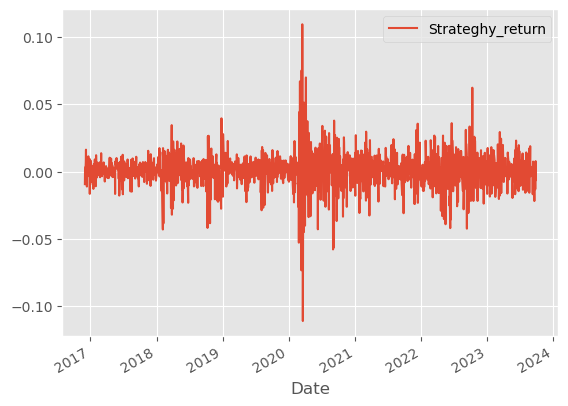

In [126]:
portfolio_df.plot()

Compare return of portfolio to benchmark (SP500)

now download SP 500 Data

In [127]:
spy = yf.download(tickers='SPY',
                  start = '2015-01-01',
                  end = dt.date.today())
spy_ret = np.log(spy[['Adj Close']]).diff().dropna()

spy_ret.columns = spy_ret.columns.droplevel(0)
spy_ret.rename({'SPY':'SPY Buy&Hold'}, axis=1, inplace=True)
spy_ret

[*********************100%***********************]  1 of 1 completed


Ticker,SPY Buy&Hold
Date,
2015-01-05,-0.018225
2015-01-06,-0.009463
2015-01-07,0.012384
2015-01-08,0.017589
2015-01-09,-0.008045
...,...
2024-12-16,0.004261
2024-12-17,-0.004129
2024-12-18,-0.030257


In [128]:
portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)
portfolio_df

#merged dataframe 

,Strateghy_return,SPY Buy&Hold
Date,,
2016-12-01,-0.009329,-0.003682
2016-12-02,0.003043,0.000501
2016-12-05,0.003208,0.005991
2016-12-06,0.007078,0.003162
2016-12-07,0.016215,0.012996
...,...,...
2023-09-25,0.002014,0.004196
2023-09-26,-0.013125,-0.014800
2023-09-27,0.005543,0.000399


In [131]:
plt.style.use('ggplot')

# get cumulative return of the portfolio and SP 500
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return

,Strateghy_return,SPY Buy&Hold
Date,,
2016-12-01,-0.009329,-0.003682
2016-12-02,-0.006314,-0.003183
2016-12-05,-0.003127,0.002789
2016-12-06,0.003929,0.005960
2016-12-07,0.020208,0.019033
...,...,...
2023-09-25,1.575273,0.950844
2023-09-26,1.541473,0.921971
2023-09-27,1.555561,0.922738


Text(0, 0.5, 'return')

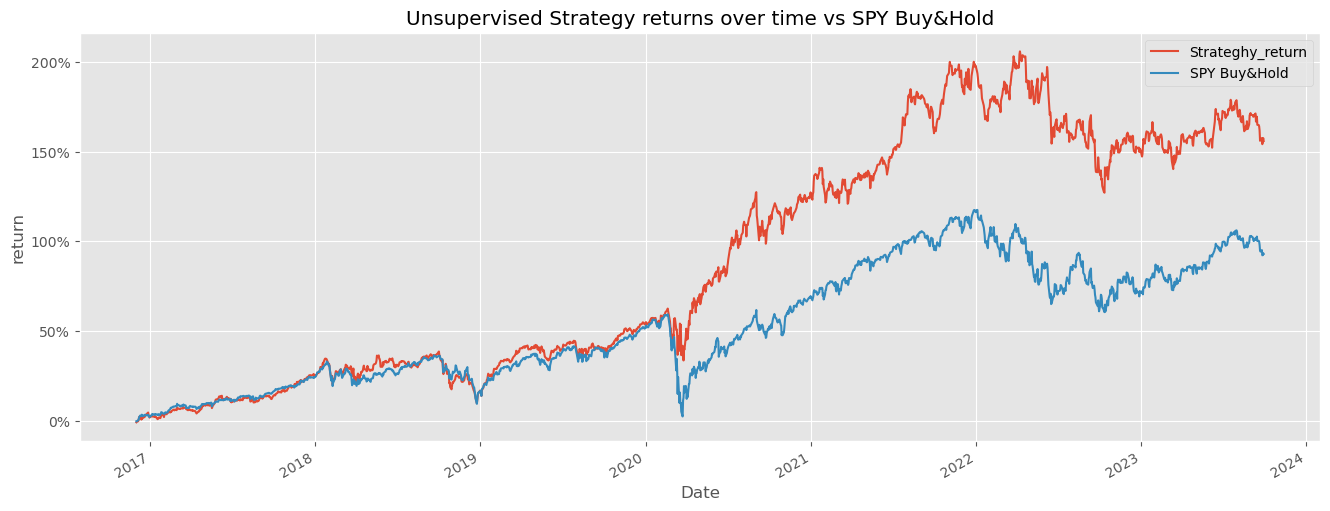

In [137]:
import matplotlib.ticker as mtick
portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))
plt.title('Unsupervised Strategy returns over time vs SPY Buy&Hold')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.ylabel('return')